# Amoukou Salim

## First let create a class which manage the Markov decision process and its solution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self,T,R,discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (self.nActions,self.nStates,self.nStates), "Invalid transition function: it has dimensionality " + repr(T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(2)-1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions" 
        assert R.shape == (self.nActions,self.nStates), "Invalid reward function: it has dimensionality " + repr(R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount
#Change        
    def valueIteration(self,initialV,nIterations=np.inf,tolerance=0.01):
        '''Value iteration procedure
        V <-- max_a R^a + gamma T^a V

        Inputs:
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''
        
        V = initialV
        iterId = 0
        while iterId < nIterations:
            Q = self.R + self.discount*np.dot(self.T,V)
            newV = Q.max(0)
            epsilon = np.linalg.norm(newV - V, np.inf)
            V = newV
            iterId += 1
            if epsilon <= tolerance: break
        #return [V,iterId,epsilon]
        return self.R + self.discount*np.dot(self.T,V)
    def extractPolicy(self,V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        Q = self.R + self.discount*np.dot(self.T,V)
        policy = Q.argmax(0)
        return policy 

    def evaluatePolicy(self,policy):
        '''Evaluate a policy by solving a system of linear equations
        V^pi = R^pi + gamma T^pi V^pi

        Input:
        policy -- Policy: array of |S| entries

        Ouput:
        V -- Value function: array of |S| entries'''

        T = self.T[policy,np.arange(self.nStates),:]
        R = self.R[policy,np.arange(self.nStates)]
        A = np.identity(self.nStates) - self.discount*T
        V = np.linalg.solve(A,R)
        return V
        
    def policyIteration(self,initialPolicy,nIterations=np.inf):
        '''Policy iteration procedure: alternate between policy
        evaluation (solve V^pi = R^pi + gamma T^pi V^pi) and policy
        improvement (pi <-- argmax_a R^a + gamma T^a V^pi).

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        nIterations -- limit on # of iterations: scalar (default: inf)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        policy = initialPolicy
        V = self.evaluatePolicy(policy)
        iterId = 0
        while iterId < nIterations:
            newPolicy = self.extractPolicy(V)
            iterId += 1
            if (newPolicy == policy).all(): break
            policy = newPolicy
            V = self.evaluatePolicy(policy)
        return [policy,V,iterId]
            
    def evaluatePolicyPartially(self,policy,initialV,nIterations=np.inf,tolerance=0.01):
        '''Partial policy evaluation:
        Repeat V^pi <-- R^pi + gamma T^pi V^pi

        Inputs:
        policy -- Policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        V = initialV
        T = self.T[policy,np.arange(self.nStates),:]
        R = self.R[policy,np.arange(self.nStates)]
        iterId = 0
        while iterId < nIterations:
            newV = R + self.discount*np.dot(T,V)
            epsilon = np.linalg.norm(newV - V, np.inf)
            V = newV
            iterId += 1
            if epsilon <= tolerance: break
        return [V,iterId,epsilon]

    def modifiedPolicyIteration(self,initialPolicy,initialV,nEvalIterations=5,nIterations=np.inf,tolerance=0.01):
        '''Modified policy iteration procedure: alternate between
        partial policy evaluation (repeat a few times V^pi <-- R^pi + gamma T^pi V^pi)
        and policy improvement (pi <-- argmax_a R^a + gamma T^a V^pi)

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nEvalIterations -- limit on # of iterations to be performed in each partial policy evaluation: scalar (default: 5)
        nIterations -- limit on # of iterations to be performed in modified policy iteration: scalar (default: inf)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        policy = initialPolicy
        V = initialV
        iterId = 0
        while iterId < nIterations:
            [V,_,_] = self.evaluatePolicyPartially(policy,V,nIterations=nEvalIterations)
            newPolicy = self.extractPolicy(V)
            [newV,_,_] = self.valueIteration(initialV=V,nIterations=1)
            epsilon = np.linalg.norm(newV - V, np.inf)
            policy = newPolicy
            V = newV
            iterId += 1
            if epsilon < tolerance: break
        return [policy,V,iterId,epsilon]
        



## MDP Example with maze problem

In [33]:
def create_maze_by_theta(the):
    ''' Construct a simple maze MDP

    Grid world layout:

    ---------------------
    |  0 |  1 |  2 |  3 |
    ---------------------
    |  4 |  5 |  6 |  7 |
    ---------------------
    |  8 |  9 | 10 | 11 |
    ---------------------
    | 12 | 13 | 14 | 15 |
    ---------------------

    Goal state: 15 
    Bad state: 9
    End state: 16

    The end state is an absorbing state that the agent transitions 
    to after visiting the goal state.

    There are 17 states in total (including the end state) 
    and 4 actions (up, down, left, right).'''

    # Transition function: |A| x |S| x |S'| array
    T = np.zeros([4,17,17])
    a = the;  # intended move
    b = (1-the)/2;  # lateral move

    # up (a = 0)

    T[0,0,0] = a+b;
    T[0,0,1] = b;

    T[0,1,0] = b;
    T[0,1,1] = a;
    T[0,1,2] = b;

    T[0,2,1] = b;
    T[0,2,2] = a;
    T[0,2,3] = b;

    T[0,3,2] = b;
    T[0,3,3] = a+b;

    T[0,4,4] = b;
    T[0,4,0] = a;
    T[0,4,5] = b;

    T[0,5,4] = b;
    T[0,5,1] = a;
    T[0,5,6] = b;

    T[0,6,5] = b;
    T[0,6,2] = a;
    T[0,6,7] = b;

    T[0,7,6] = b;
    T[0,7,3] = a;
    T[0,7,7] = b;

    T[0,8,8] = b;
    T[0,8,4] = a;
    T[0,8,9] = b;

    T[0,9,8] = b;
    T[0,9,5] = a;
    T[0,9,10] = b;

    T[0,10,9] = b;
    T[0,10,6] = a;
    T[0,10,11] = b;

    T[0,11,10] = b;
    T[0,11,7] = a;
    T[0,11,11] = b;

    T[0,12,12] = b;
    T[0,12,8] = a;
    T[0,12,13] = b;

    T[0,13,12] = b;
    T[0,13,9] = a;
    T[0,13,14] = b;

    T[0,14,13] = b;
    T[0,14,10] = a;
    T[0,14,15] = b;

    T[0,15,16] = 1;
    T[0,16,16] = 1;

    # down (a = 1)

    T[1,0,0] = b;
    T[1,0,4] = a;
    T[1,0,1] = b;

    T[1,1,0] = b;
    T[1,1,5] = a;
    T[1,1,2] = b;

    T[1,2,1] = b;
    T[1,2,6] = a;
    T[1,2,3] = b;

    T[1,3,2] = b;
    T[1,3,7] = a;
    T[1,3,3] = b;

    T[1,4,4] = b;
    T[1,4,8] = a;
    T[1,4,5] = b;

    T[1,5,4] = b;
    T[1,5,9] = a;
    T[1,5,6] = b;

    T[1,6,5] = b;
    T[1,6,10] = a;
    T[1,6,7] = b;

    T[1,7,6] = b;
    T[1,7,11] = a;
    T[1,7,7] = b;

    T[1,8,8] = b;
    T[1,8,12] = a;
    T[1,8,9] = b;

    T[1,9,8] = b;
    T[1,9,13] = a;
    T[1,9,10] = b;

    T[1,10,9] = b;
    T[1,10,14] = a;
    T[1,10,11] = b;

    T[1,11,10] = b;
    T[1,11,15] = a;
    T[1,11,11] = b;

    T[1,12,12] = a+b;
    T[1,12,13] = b;

    T[1,13,12] = b;
    T[1,13,13] = a;
    T[1,13,14] = b;

    T[1,14,13] = b;
    T[1,14,14] = a;
    T[1,14,15] = b;

    T[1,15,16] = 1;
    T[1,16,16] = 1;

    # left (a = 2)

    T[2,0,0] = a+b;
    T[2,0,4] = b;

    T[2,1,1] = b;
    T[2,1,0] = a;
    T[2,1,5] = b;

    T[2,2,2] = b;
    T[2,2,1] = a;
    T[2,2,6] = b;

    T[2,3,3] = b;
    T[2,3,2] = a;
    T[2,3,7] = b;

    T[2,4,0] = b;
    T[2,4,4] = a;
    T[2,4,8] = b;

    T[2,5,1] = b;
    T[2,5,4] = a;
    T[2,5,9] = b;

    T[2,6,2] = b;
    T[2,6,5] = a;
    T[2,6,10] = b;

    T[2,7,3] = b;
    T[2,7,6] = a;
    T[2,7,11] = b;

    T[2,8,4] = b;
    T[2,8,8] = a;
    T[2,8,12] = b;

    T[2,9,5] = b;
    T[2,9,8] = a;
    T[2,9,13] = b;

    T[2,10,6] = b;
    T[2,10,9] = a;
    T[2,10,14] = b;

    T[2,11,7] = b;
    T[2,11,10] = a;
    T[2,11,15] = b;

    T[2,12,8] = b;
    T[2,12,12] = a+b;

    T[2,13,9] = b;
    T[2,13,12] = a;
    T[2,13,13] = b;

    T[2,14,10] = b;
    T[2,14,13] = a;
    T[2,14,14] = b;

    T[2,15,16] = 1;
    T[2,16,16] = 1;

    # right (a = 3)

    T[3,0,0] = b;
    T[3,0,1] = a;
    T[3,0,4] = b;

    T[3,1,1] = b;
    T[3,1,2] = a;
    T[3,1,5] = b;

    T[3,2,2] = b;
    T[3,2,3] = a;
    T[3,2,6] = b;

    T[3,3,3] = a+b;
    T[3,3,7] = b;

    T[3,4,0] = b;
    T[3,4,5] = a;
    T[3,4,8] = b;

    T[3,5,1] = b;
    T[3,5,6] = a;
    T[3,5,9] = b;

    T[3,6,2] = b;
    T[3,6,7] = a;
    T[3,6,10] = b;

    T[3,7,3] = b;
    T[3,7,7] = a;
    T[3,7,11] = b;

    T[3,8,4] = b;
    T[3,8,9] = a;
    T[3,8,12] = b;

    T[3,9,5] = b;
    T[3,9,10] = a;
    T[3,9,13] = b;

    T[3,10,6] = b;
    T[3,10,11] = a;
    T[3,10,14] = b;

    T[3,11,7] = b;
    T[3,11,11] = a;
    T[3,11,15] = b;

    T[3,12,8] = b;
    T[3,12,13] = a;
    T[3,12,12] = b;

    T[3,13,9] = b;
    T[3,13,14] = a;
    T[3,13,13] = b;

    T[3,14,10] = b;
    T[3,14,15] = a;
    T[3,14,14] = b;

    T[3,15,16] = 1;
    T[3,16,16] = 1;

    # Reward function: |A| x |S| array
    R = -1 * np.ones([4,17]);

    # set rewards
    R[:,15] = 100;  # goal state
    R[:,9] = -70;   # bad state
    R[:,16] = 0;    # end state

    # Discount factor: scalar in [0,1)
    discount = 0.95

    # MDP object
    mdp = MDP(T,R,discount)
    return mdp



# Second let compute posterior in the case of Maze problem

 In order to apply Bayesian Reinforcement leanrning (Thompson sampling to MDP's params), we first define a function which compute posterior in the maze problem case

In [ ]:

def update_prior(a,b,action,state,nextstate):
    if action == 0:
        if (state == 0 and nextstate==0) or (state ==1 and nextstate==1) or (state ==2 and nextstate==2) or (state ==3 and nextstate==3):
            a = a + 1
        elif state == nextstate+4:
            a = a + 1
        else:
            b = b + 1

    if action == 1:
        if (state == 12 and nextstate==12) or (state ==13 and nextstate==13) or (state ==14 and nextstate==14) or (state ==15 and nextstate==15):
            a = a + 1
        elif state == nextstate - 4:
            a = a + 1
        else:
            b = b + 1
    if action == 2:
        if (state == 0 and nextstate==0) or (state ==4 and nextstate==4) or (state ==8 and nextstate==8) or (state ==12 and nextstate==12):
            a = a + 1
        elif state == nextstate + 1:
            a = a + 1
        else:
            b = b + 1

    if action == 3:
        if (state == 3 and nextstate==3) or (state ==7 and nextstate==7) or (state ==11 and nextstate==11) or (state ==15 and nextstate==15):
            a = a + 1
        elif state == nextstate - 1:
            a = a + 1
        else:
            b = b + 1
    return a,b

## Finally, let solve the RL problem with Bayesian 

A class which create the RL problem (Maze problem) and use Bayesian Reinforcement learning to solve it.

In [30]:
from scipy.stats import beta
import numpy as np
class TS_RL:
    def __init__(self,th):
        '''Constructor for the RL2 class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''
        self.liste_of_state = []
        self.mdp = create_maze_by_theta(th)
    
    def sampleRewardAndNextState(self,state,action):
        '''Procedure to sample a reward and the next state
        reward ~ determinics
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.mdp.R[action,state]
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]
    
    def TS(self,n_iter=1000,k=1):
        state = 0
        a = 1
        b = 1
        self.liste_of_state = [(a,b)]
        for i in range(n_iter):
            theta = beta.rvs(a,b,size=k)
            MDPs = [create_maze_by_theta(d) for d in theta]
            Q_functions = [m.valueIteration(np.zeros(17)) for m in MDPs]
        
            Q_hat = np.mean(Q_functions,axis=0)
            #print(i)
            #print(Q_hat)
            policy_hat = Q_hat.argmin(0)
            #print(policy_hat)
            
            action = policy_hat[state]
            [reward,nextstate] = self.sampleRewardAndNextState(state,action)
            #Update prior
            a,b = update_prior(a,b,action,state,nextstate)
            #print('evolution of (a={},b={})'.format(a,b))
                    
            self.liste_of_state.append((a,b))
            state = nextstate
            

        
        #for i,(f,g) in enumerate(liste_of_state[:10]):
        #    pdf = beta(f, g).pdf(x)
        #    plt.plot(x, pdf,label=i, alpha=.6)
        #plt.title("Beta distributions")
        #plt.legend();
        #Let's plot the distribution
            
        return Q_hat,self.liste_of_state
    
    def afficher_last_prior(self):
        x = np.arange(0, 1, 0.0001)
        for i,(f,g) in enumerate(self.liste_of_state[-10:]):
            pdf = beta(f, g).pdf(x)
            plt.plot(x, pdf,label=i, alpha=.6)
        plt.title("Beta distributions")
        plt.legend();
        
    def afficher_first_prior(self):
        x = np.arange(0, 1, 0.0001)
        for i,(f,g) in enumerate(self.liste_of_state[:10]):
            pdf = beta(f, g).pdf(x)
            plt.plot(x, pdf,label=i, alpha=.6)
        plt.title("Beta distributions")
        plt.legend();
    def return_best_parameter(self):
        (a_star,b_star) = self.liste_of_state[-1]
        theta_star = np.mean(beta.rvs(a_star,b_star,size=1000))
        return theta_star
    

In [31]:
#Test

In [22]:
#rlProblem = TS_RL(0.1)
#dq,l = rlProblem.TS()

evolution of (a=1,b=2)
evolution of (a=1,b=3)
evolution of (a=1,b=4)
evolution of (a=1,b=5)
evolution of (a=1,b=6)
evolution of (a=1,b=7)
evolution of (a=1,b=8)
evolution of (a=1,b=9)
evolution of (a=1,b=10)
evolution of (a=1,b=11)
evolution of (a=1,b=12)
evolution of (a=1,b=13)
evolution of (a=1,b=14)
evolution of (a=1,b=15)
evolution of (a=1,b=16)
evolution of (a=1,b=17)
evolution of (a=1,b=18)
evolution of (a=1,b=19)
evolution of (a=1,b=20)
evolution of (a=2,b=20)
evolution of (a=2,b=21)
evolution of (a=2,b=22)
evolution of (a=2,b=23)
evolution of (a=3,b=23)
evolution of (a=3,b=24)
evolution of (a=3,b=25)
evolution of (a=3,b=26)
evolution of (a=3,b=27)
evolution of (a=3,b=28)
evolution of (a=3,b=29)
evolution of (a=4,b=29)
evolution of (a=5,b=29)
evolution of (a=5,b=30)
evolution of (a=5,b=31)
evolution of (a=5,b=32)
evolution of (a=5,b=33)
evolution of (a=6,b=33)
evolution of (a=6,b=34)
evolution of (a=6,b=35)
evolution of (a=6,b=36)
evolution of (a=6,b=37)
evolution of (a=6,b=38)


evolution of (a=51,b=352)
evolution of (a=52,b=352)
evolution of (a=52,b=353)
evolution of (a=53,b=353)
evolution of (a=53,b=354)
evolution of (a=53,b=355)
evolution of (a=53,b=356)
evolution of (a=53,b=357)
evolution of (a=53,b=358)
evolution of (a=54,b=358)
evolution of (a=54,b=359)
evolution of (a=54,b=360)
evolution of (a=54,b=361)
evolution of (a=55,b=361)
evolution of (a=55,b=362)
evolution of (a=55,b=363)
evolution of (a=55,b=364)
evolution of (a=55,b=365)
evolution of (a=56,b=365)
evolution of (a=56,b=366)
evolution of (a=56,b=367)
evolution of (a=56,b=368)
evolution of (a=56,b=369)
evolution of (a=56,b=370)
evolution of (a=56,b=371)
evolution of (a=56,b=372)
evolution of (a=56,b=373)
evolution of (a=56,b=374)
evolution of (a=56,b=375)
evolution of (a=56,b=376)
evolution of (a=56,b=377)
evolution of (a=57,b=377)
evolution of (a=57,b=378)
evolution of (a=57,b=379)
evolution of (a=57,b=380)
evolution of (a=57,b=381)
evolution of (a=58,b=381)
evolution of (a=59,b=381)
evolution of

evolution of (a=124,b=671)
evolution of (a=125,b=671)
evolution of (a=125,b=672)
evolution of (a=126,b=672)
evolution of (a=126,b=673)
evolution of (a=127,b=673)
evolution of (a=127,b=674)
evolution of (a=127,b=675)
evolution of (a=128,b=675)
evolution of (a=128,b=676)
evolution of (a=128,b=677)
evolution of (a=128,b=678)
evolution of (a=128,b=679)
evolution of (a=129,b=679)
evolution of (a=130,b=679)
evolution of (a=131,b=679)
evolution of (a=131,b=680)
evolution of (a=132,b=680)
evolution of (a=132,b=681)
evolution of (a=132,b=682)
evolution of (a=132,b=683)
evolution of (a=132,b=684)
evolution of (a=132,b=685)
evolution of (a=133,b=685)
evolution of (a=134,b=685)
evolution of (a=134,b=686)
evolution of (a=134,b=687)
evolution of (a=134,b=688)
evolution of (a=134,b=689)
evolution of (a=134,b=690)
evolution of (a=134,b=691)
evolution of (a=134,b=692)
evolution of (a=134,b=693)
evolution of (a=134,b=694)
evolution of (a=134,b=695)
evolution of (a=134,b=696)
evolution of (a=134,b=697)
e

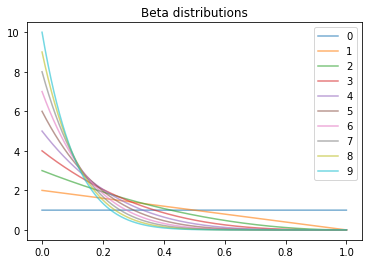

In [25]:
#rlProblem.afficher_first_prior()